In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

%matplotlib inline

In [18]:
df_drivers = pd.read_csv('driver_ids.csv', parse_dates=['driver_onboard_date'])
df_rides = pd.read_csv('ride_ids.csv')
df_rtsp = pd.read_csv('ride_timestamps_pvt.csv', parse_dates=['accepted_at', 'arrived_at', 'dropped_off_at', 'picked_up_at', 'requested_at'])
df_r = pd.read_csv('rides_revenue.csv', parse_dates=['driver_onboard_date', 'dropped_off_at'])

### Assumptions

Since we only have at most 1.5 months of post-onboarding data for all drivers we need to make a few churn assumptions:
* All drivers (denominator) = Drivers who’ve completed a ride in their first **3 weeks**
* Churners = Drivers who’ve completed a ride in their first **3 weeks** but didn’t complete a ride **after that**

In [19]:
# Get how many days a ride was from a drivers onboarding date
df_r['days_since_onboarding'] = (df_r['dropped_off_at'] - df_r['driver_onboard_date']).dt.days

# Rank the rides per driver
df_r['driver_ride_num'] = df_r.groupby('driver_id')['dropped_off_at'].rank(ascending=True)

# Turn the time to accept into seconds. We'll use this later
df_r['time_to_accept'] = pd.to_timedelta(df_r['time_to_accept']).dt.seconds

In [20]:
# Get a list of all drivers
list_of_all_drivers = df_r['driver_id'].unique()

# Get a list of drivers who've done a ride after N days since onboarding. This means they have *not* churned by our assumption
drivers_active_after_21_days = df_r[df_r['days_since_onboarding'] > 24]['driver_id'].unique()

# Find the users who appear on the list of all drivers, but don't appear on the +21 days list. These are the ones who've churned
churned_drivers = np.setdiff1d(list_of_all_drivers, drivers_active_after_21_days)

# print ("Total Drivers: {}".format(len(list_of_all_drivers)))
# print ("Num Churned Drivers: {}".format(len(churned_drivers)))
# print ("21 Day Churn post-onboarding Churn Rate: {}".format(len(churned_drivers) / len(list_of_all_drivers)))

### Create your churn table to get ready for RandomForests

In [21]:
df = pd.DataFrame(list_of_all_drivers, columns=['driver_id'])
df['churn_ind'] = df['driver_id'].apply(lambda x: x in churned_drivers)

In [22]:
df = pd.merge(df, df_drivers, how='left', on=['driver_id'])

In [23]:
# Get number of rides a driver did in their first week and join to your bigger df
rides_in_first_week = df_r[df_r['days_since_onboarding'] <= 7].groupby(['driver_id'])['ride_id'].nunique()
df = pd.merge(df, rides_in_first_week, how='left', on=['driver_id'])
df = df.rename(columns={"ride_id": "num_rides_first_week"})

In [24]:
# Get number of rides a driver did in their first 2 weeks and join to your bigger df
rides_in_first_2week = df_r[df_r['days_since_onboarding'] <= 14].groupby(['driver_id'])['ride_id'].nunique()
df = pd.merge(df, rides_in_first_2week, how='left', on=['driver_id'])
df = df.rename(columns={"ride_id": "rides_in_first_2week"})

In [25]:
# Get a drivers time to accept in their first two weeks
time_to_accept_first_2week = df_r[df_r['days_since_onboarding'] <= 14].groupby(['driver_id'])['time_to_accept'].sum()
df = pd.merge(df, time_to_accept_first_2week, how='left', on=['driver_id'])
df = df.rename(columns={"time_to_accept": "time_to_accept_first_2week"})

df['avg_time_to_accept_2week'] = df['time_to_accept_first_2week'] / df['rides_in_first_2week']

In [26]:
# Get revenue for a driver in their first week
revenue_in_first_week = df_r[df_r['days_since_onboarding'] <= 7].groupby(['driver_id'])['ride_revenue'].sum()
df = pd.merge(df, revenue_in_first_week, how='left', on=['driver_id'])
df = df.rename(columns={"ride_revenue": "ride_revenue_first_week"})

# Average Revenue First Week
df['average_revenue_first_week'] = df['ride_revenue_first_week'] / df['num_rides_first_week']

In [27]:
revenue_first_5_rides = df_r[df_r['driver_ride_num'] <= 5].groupby(['driver_id'])['ride_revenue'].sum()
df = pd.merge(df, revenue_first_5_rides, how='left', on=['driver_id'])
df = df.rename(columns={"ride_revenue": "revenue_first_5_rides"})

revenue_first_10_rides = df_r[df_r['driver_ride_num'] <= 10].groupby(['driver_id'])['ride_revenue'].sum()
df = pd.merge(df, revenue_first_10_rides, how='left', on=['driver_id'])
df = df.rename(columns={"ride_revenue": "revenue_first_10_rides"})

In [28]:
# Get date of the first ride and attach it to your df
df_first_ride_date = df_r[df_r['driver_ride_num'] == 1][['driver_id', 'dropped_off_at']]
df = pd.merge(df, df_first_ride_date, how='left', on=['driver_id'])
df = df.rename(columns={"dropped_off_at": "first_ride_date"})

# Get the delta of how long it took a driver to do their first ride
df['days_btw_onboard_first_ride'] = (df['first_ride_date'] - df['driver_onboard_date']).dt.days

In [29]:
# Get revenue of a drivers first ride
df_first_ride_revenue = df_r[df_r['driver_ride_num'] == 1][['driver_id', 'ride_revenue']]
df = pd.merge(df, df_first_ride_revenue, how='left', on=['driver_id'])
df = df.rename(columns={"ride_revenue": "first_ride_rev"})

In [30]:
# Fill your NaNs with 0
df.fillna(0, inplace=True)

In [31]:
# Find the increase they had between the first week and 2nd week.
# Hypothesis: If they kept the momentum going, they were more successful. If they declined, they weren't
df['first_week_momentum'] = df['rides_in_first_2week'] - df['num_rides_first_week']

In [32]:
# Drop the rows you don't need
df.drop(['driver_onboard_date', 'days_btw_onboard_first_ride', 'first_ride_date', 'driver_id'], axis=1, inplace=True)

df['churn_ind'] = df['churn_ind'].astype(int)

df['rand'] = [1]*len(df)

### Code up your RandomForests

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df['churn_ind'], test_size=0.3, random_state=42)
print (X_train.columns)

Index(['num_rides_first_week', 'rides_in_first_2week',
       'time_to_accept_first_2week', 'avg_time_to_accept_2week',
       'ride_revenue_first_week', 'average_revenue_first_week',
       'revenue_first_5_rides', 'revenue_first_10_rides', 'first_ride_rev',
       'first_week_momentum', 'rand'],
      dtype='object')


In [34]:
clf = RandomForestClassifier(max_depth=10, n_estimators=1000)
clf.fit(X_train, y_train)

# print ("Regular Score is {}".format(clf.score(X_test, y_test)))
# print ("F1 Score Is {}".format(f1_score(y_test, clf.predict(X_test), average='macro')))
# print ("Model predicted {} churners".format(sum(clf.predict(X_test))))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

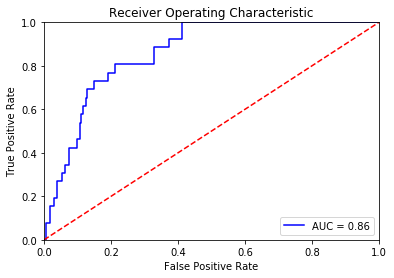

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
# print (roc_auc)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
pd.DataFrame(zip(X_train.columns, clf.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
1,rides_in_first_2week,0.139220
9,first_week_momentum,0.119645
4,ride_revenue_first_week,0.105096
6,revenue_first_5_rides,0.103751
2,time_to_accept_first_2week,0.102319
7,revenue_first_10_rides,0.096271
0,num_rides_first_week,0.095633
8,first_ride_rev,0.083085
5,average_revenue_first_week,0.078444
3,avg_time_to_accept_2week,0.076536
